### 1、导入所需的库

In [12]:
import numpy as np

import pandas as pd
pd.set_option('display.float_format', lambda x: '{:.2f}'.format(x)) #指定pandas显示格式的功能

import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#忽略警告
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

from sklearn.preprocessing import LabelEncoder

### 2、查看数据集

In [13]:
train = pd.read_csv('train.csv')
print('The shape of training data:', train.shape)
train.head()

The shape of training data: (1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
test = pd.read_csv('test.csv')
print('The shape of testing data:', test.shape)
test.head()

The shape of testing data: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.00,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.00,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.00,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.00,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.00,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [15]:
#ID列没有用，直接删掉
train.drop('Id', axis=1, inplace=True)
test.drop('Id', axis=1, inplace=True)
print('The shape of training data:', train.shape)
print('The shape of testing data:', test.shape)

The shape of training data: (1460, 80)
The shape of testing data: (1459, 79)


### 3、目标值分析：分析目标值分布、其他变量与目标值的关系

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

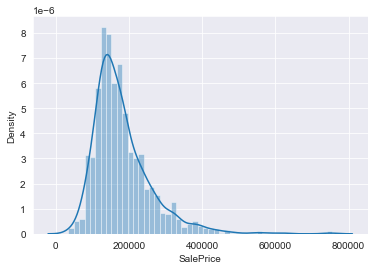

In [16]:
#绘制目标值分布
sns.distplot(train['SalePrice'])

In [17]:
train['SalePrice'].describe()

count     1460.00
mean    180921.20
std      79442.50
min      34900.00
25%     129975.00
50%     163000.00
75%     214000.00
max     755000.00
Name: SalePrice, dtype: float64

#### 由上图可知：
* 目标值右偏
* 分布曲线有尖峰

In [18]:
#分离数字特征和类别特征
num_features = []
cate_features = []
for col in test.columns:
    if test[col].dtype == 'object':
        cate_features.append(col)
    else:
        num_features.append(col)
print('number of numeric features:', len(num_features))
print('number of categorical features:', len(cate_features))

number of numeric features: 36
number of categorical features: 43


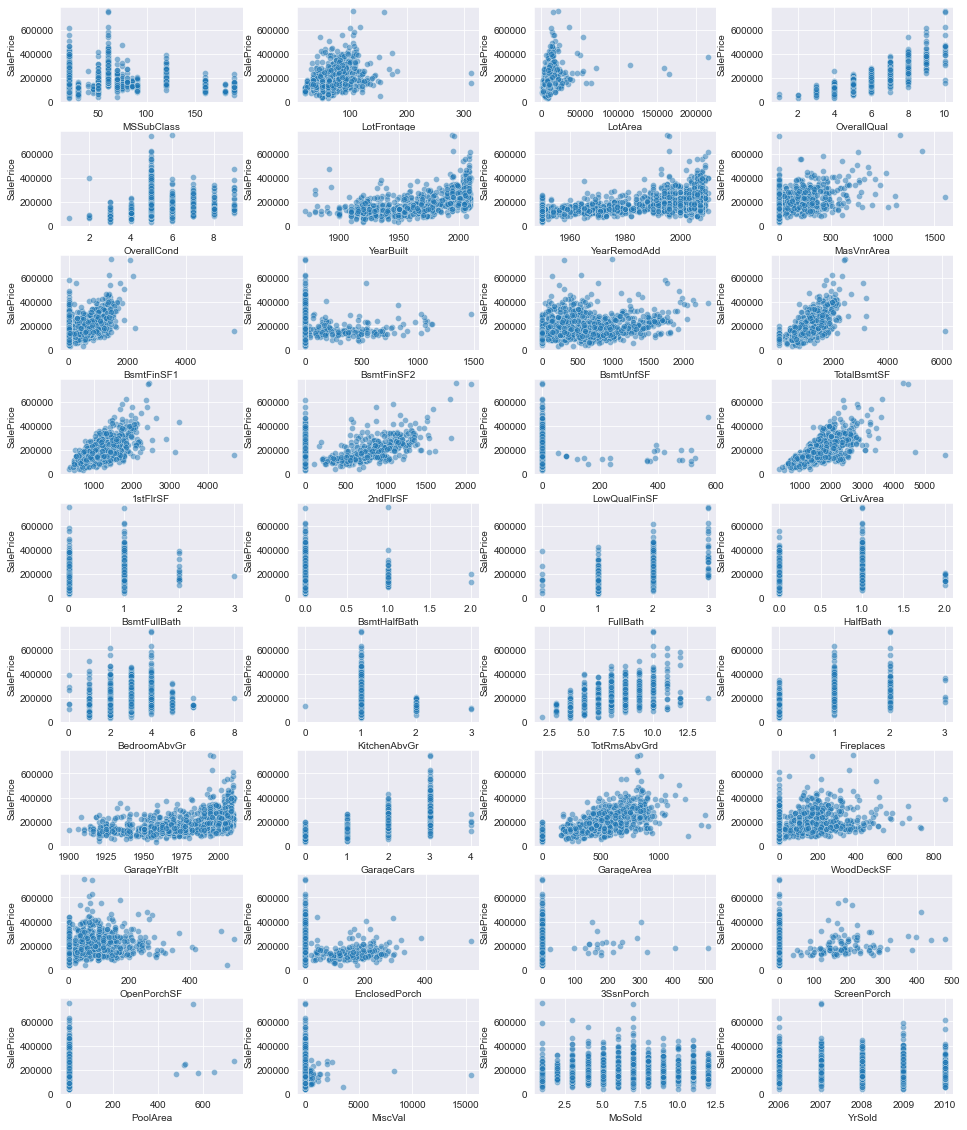

In [19]:
#查看数字特征与目标值的关系
plt.figure(figsize=(16, 20))
plt.subplots_adjust(hspace=0.3, wspace=0.3)
for i, feature in enumerate(num_features):
    plt.subplot(9, 4, i+1)
    sns.scatterplot(x=feature, y='SalePrice', data=train, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('SalePrice')
plt.show()

#### 'TotalBsmtSF'、'GrLiveArea'与目标值呈明显的线性关系

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24]),
 [Text(0, 0, 'CollgCr'),
  Text(1, 0, 'Veenker'),
  Text(2, 0, 'Crawfor'),
  Text(3, 0, 'NoRidge'),
  Text(4, 0, 'Mitchel'),
  Text(5, 0, 'Somerst'),
  Text(6, 0, 'NWAmes'),
  Text(7, 0, 'OldTown'),
  Text(8, 0, 'BrkSide'),
  Text(9, 0, 'Sawyer'),
  Text(10, 0, 'NridgHt'),
  Text(11, 0, 'NAmes'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'IDOTRR'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Edwards'),
  Text(16, 0, 'Timber'),
  Text(17, 0, 'Gilbert'),
  Text(18, 0, 'StoneBr'),
  Text(19, 0, 'ClearCr'),
  Text(20, 0, 'NPkVill'),
  Text(21, 0, 'Blmngtn'),
  Text(22, 0, 'BrDale'),
  Text(23, 0, 'SWISU'),
  Text(24, 0, 'Blueste')])

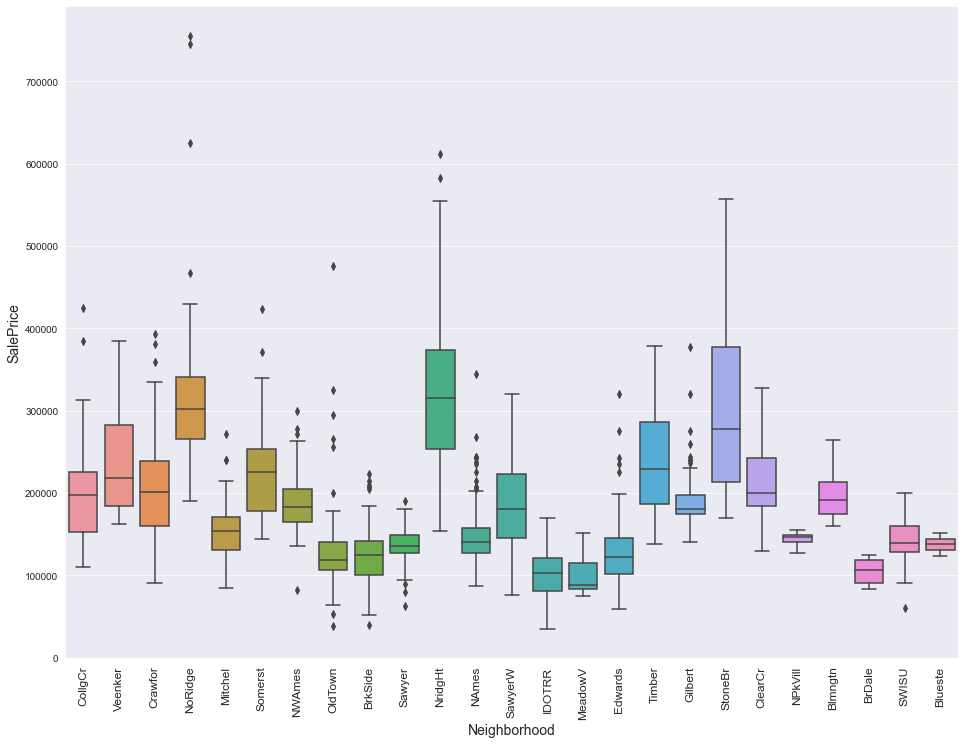

In [20]:
#查看‘Neighborhood’与目标值的关系
plt.figure(figsize=(16, 12))
sns.boxplot(x='Neighborhood', y='SalePrice', data=train)
plt.xlabel('Neighborhood', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)

#### 不同的邻居类型房价的分布模式不同

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, '2006'),
  Text(1, 0, '2007'),
  Text(2, 0, '2008'),
  Text(3, 0, '2009'),
  Text(4, 0, '2010')])

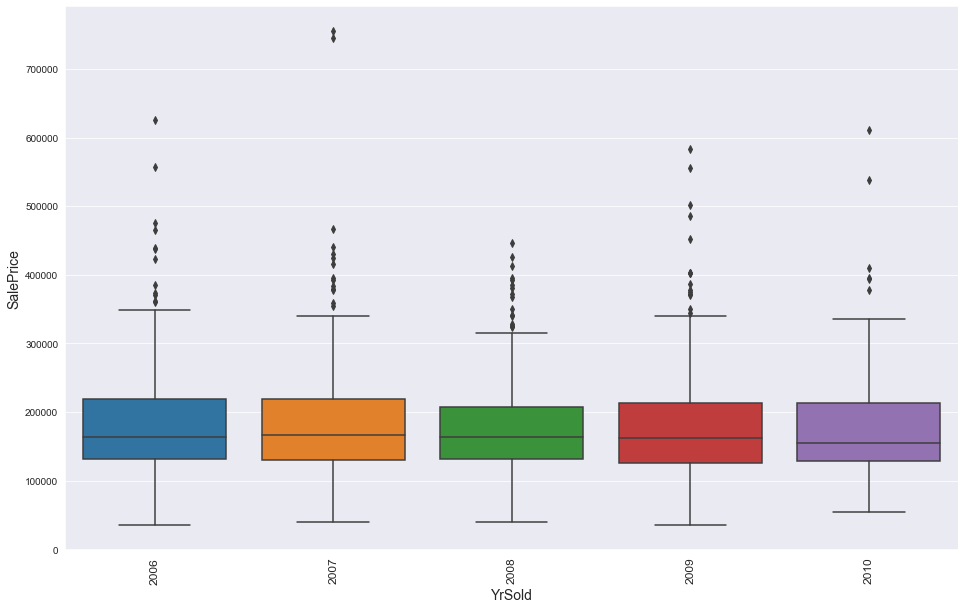

In [21]:
plt.figure(figsize=(16, 10))
sns.boxplot(x='YrSold', y='SalePrice', data=train)
plt.xlabel('YrSold', fontsize=14)
plt.ylabel('SalePrice', fontsize=14)
plt.xticks(rotation=90, fontsize=12)

#### 不同年份卖出的房价分布模式并没有太大的差别，可以认为该问题中房屋售价没有收到不同年份通货膨胀的影响，因此不考虑加入通胀等额外信息

### 4、多变量分析：分析各变量之间的关系

<AxesSubplot:>

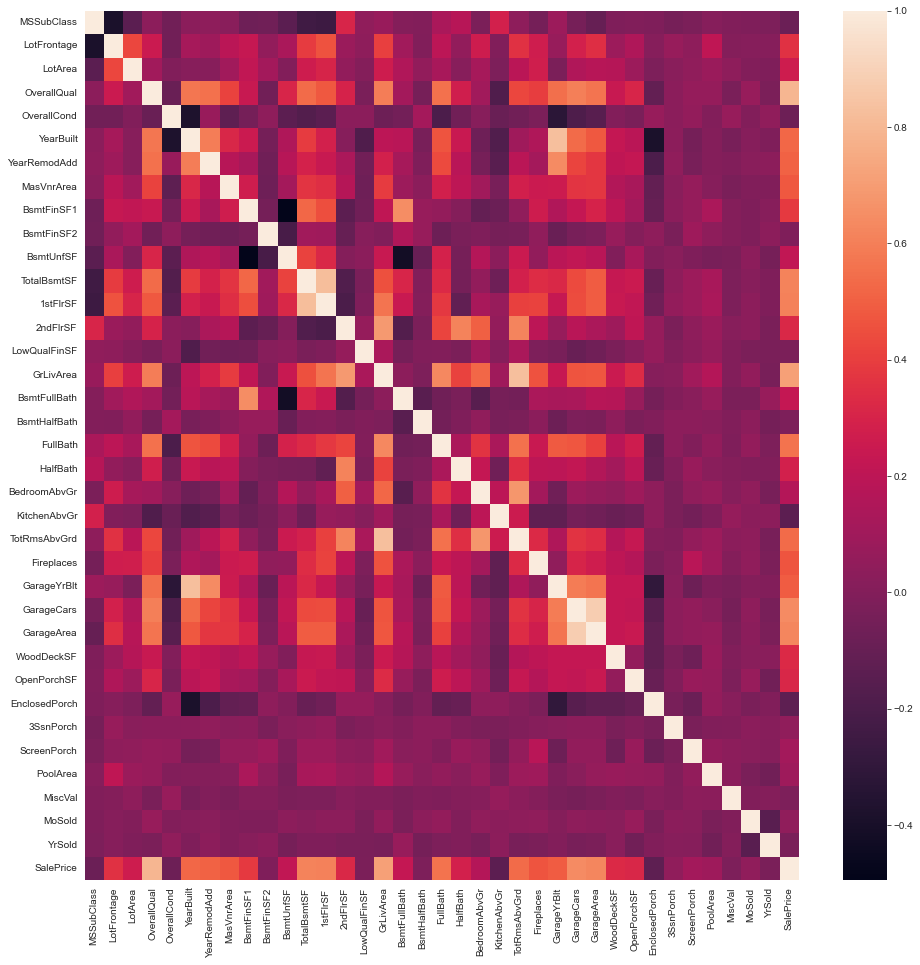

In [22]:
corrs = train.corr()
plt.figure(figsize=(16, 16))
sns.heatmap(corrs)

#### 存在较明显的相关性的变量
* ‘TotalBsmtSF’和'1stFlrSF'
* 'GarageArea'和'GarageCars'

<AxesSubplot:>

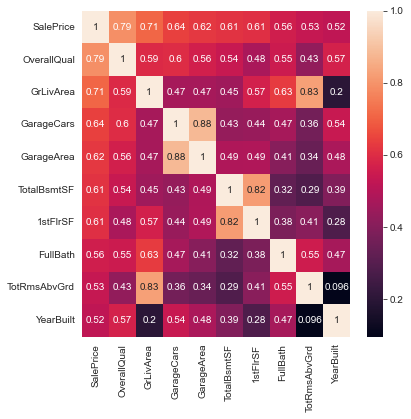

In [23]:
#分析与目标值相关度最高的十个变量
cols_10 = corrs.nlargest(10, 'SalePrice')['SalePrice'].index
corrs_10 = train[cols_10].corr()
plt.figure(figsize=(6, 6))
sns.heatmap(corrs_10, annot=True)

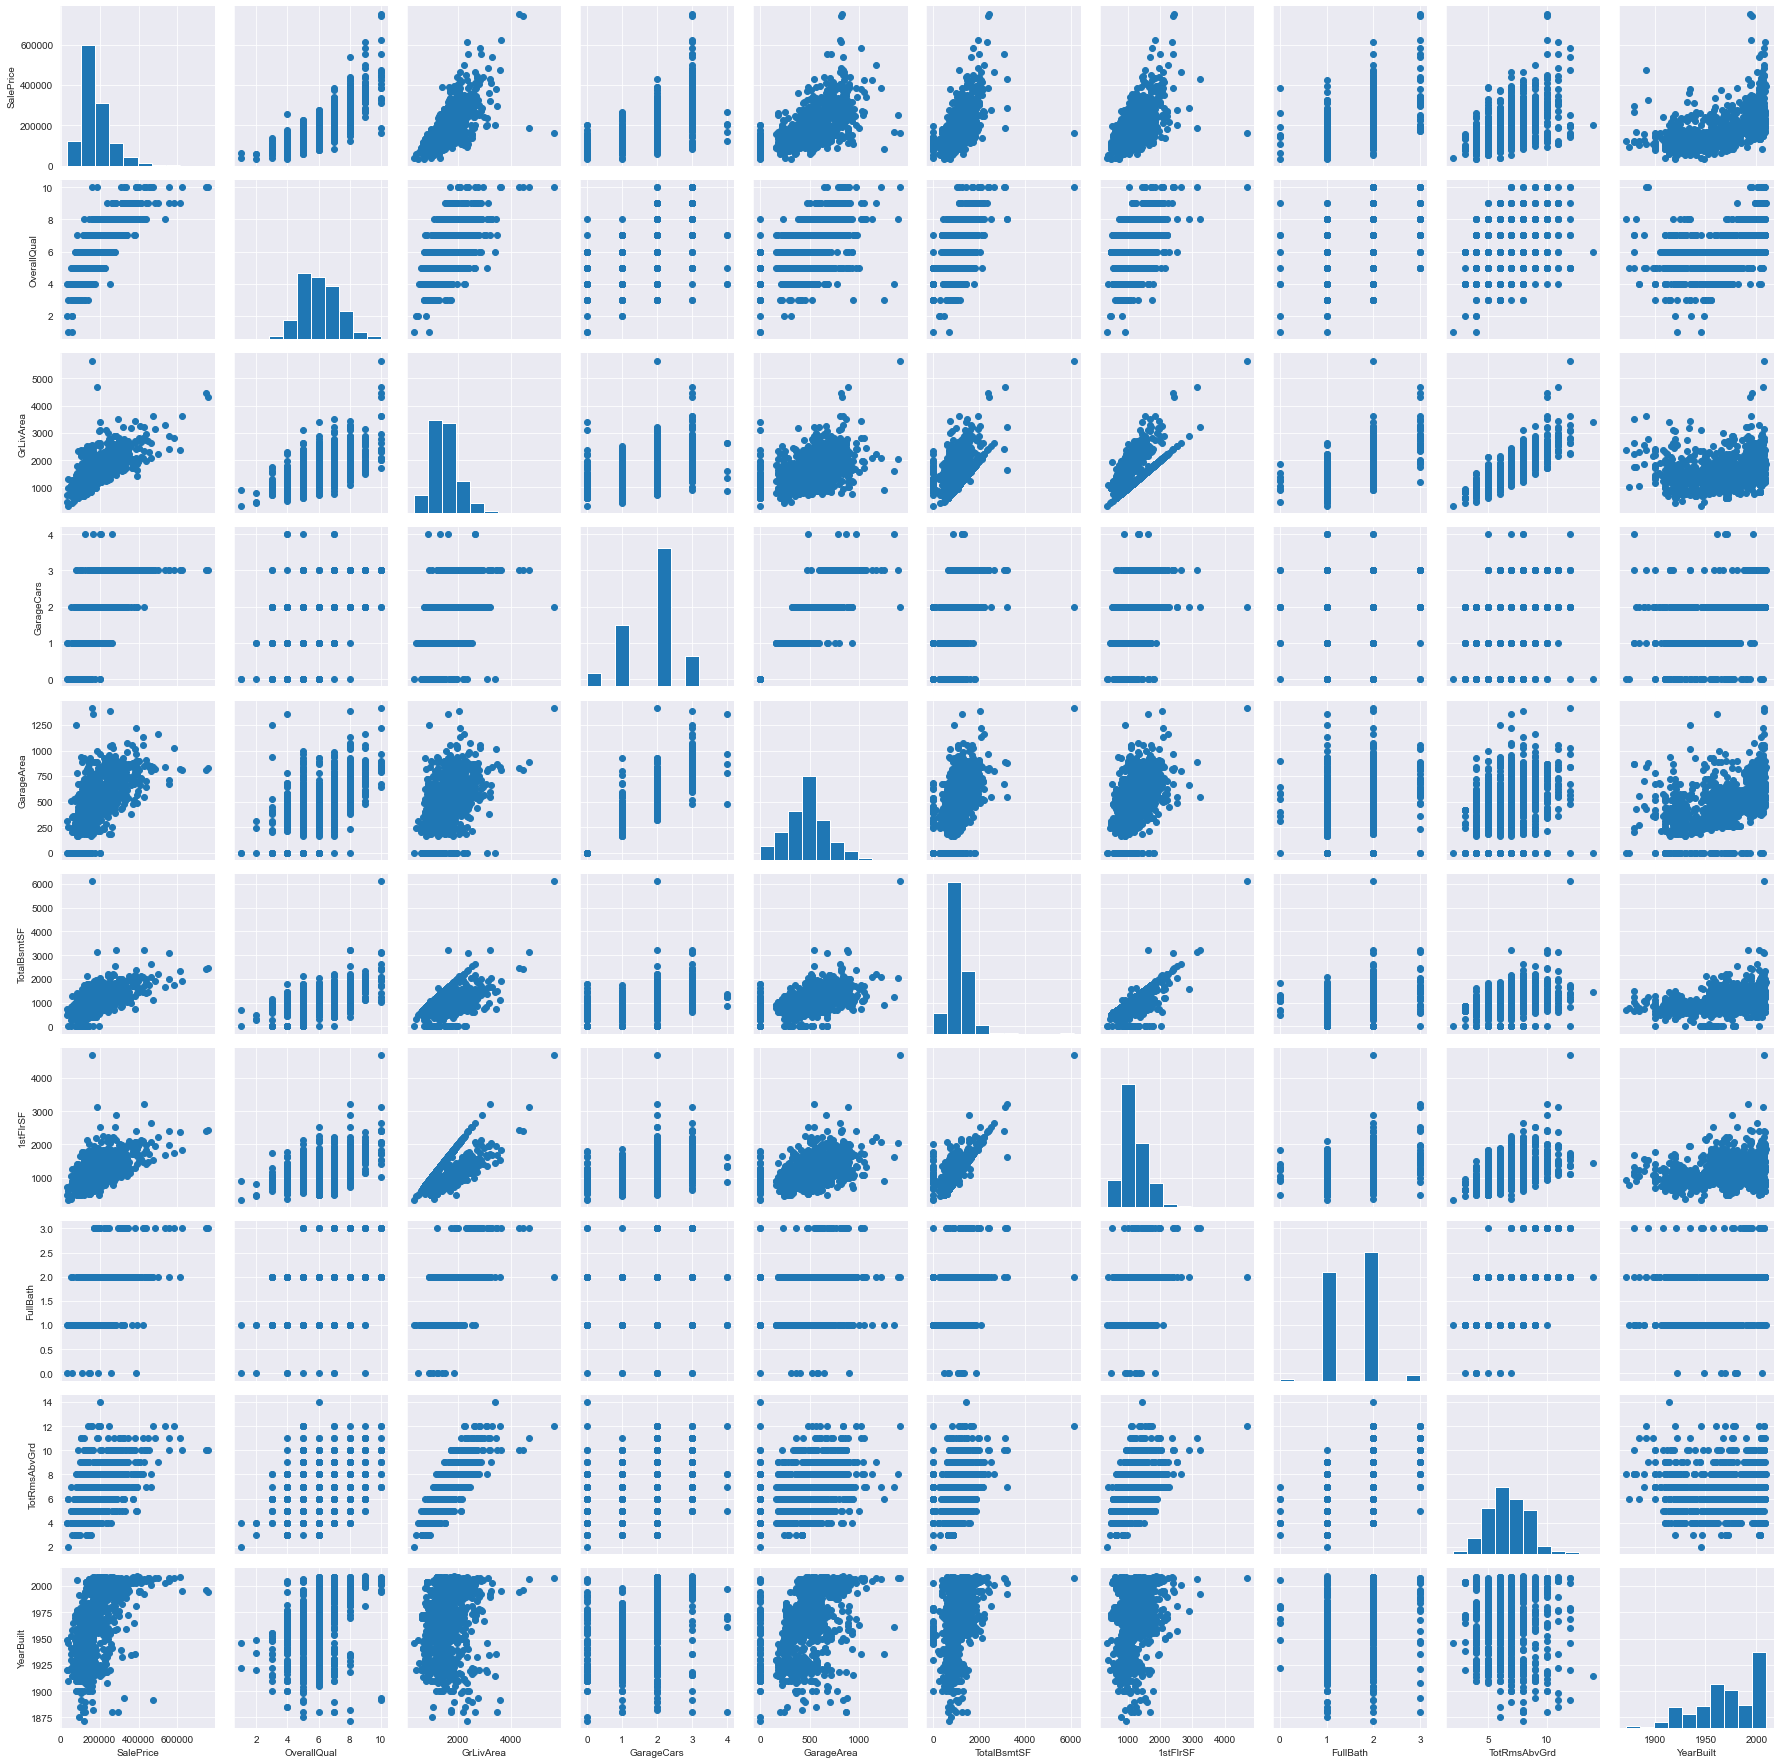

In [24]:
g = sns.PairGrid(train[cols_10])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)

### 5、异常值处理
#### 由各数字变量与目标值的关系图中观察到两组需要处理的异常值：
* 'TotalBsmtSF'
* 'GrLivArea'

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

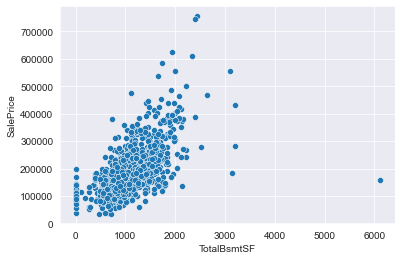

In [25]:
sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train)

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

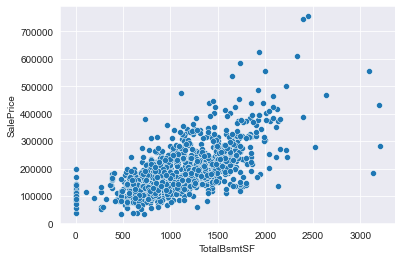

In [26]:
#处理掉右下的明显异常值
train = train.drop(train[(train['TotalBsmtSF']>6000) & (train['SalePrice']<200000)].index)

sns.scatterplot(x='TotalBsmtSF', y='SalePrice', data=train)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

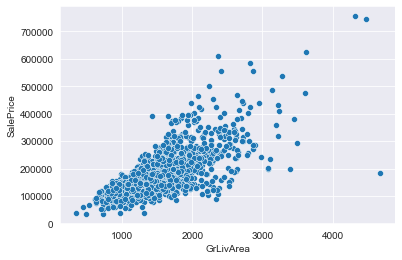

In [27]:
sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

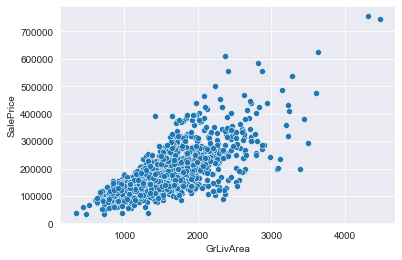

In [28]:
#处理掉右下的异常值
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<200000)].index)

sns.scatterplot(x='GrLivArea', y='SalePrice', data=train)

### 6、缺失值处理
* 先处理训练集
* 再对测试集做同样的处理

In [29]:
#查看训练集中各特征的数据缺失个数
print('The shape of training data:', train.shape)
train_missing = train.isnull().sum()
train_missing = train_missing.drop(train_missing[train_missing==0].index).sort_values(ascending=False)
train_missing

The shape of training data: (1458, 80)


PoolQC          1452
MiscFeature     1404
Alley           1367
Fence           1177
FireplaceQu      690
LotFrontage      259
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtExposure      38
BsmtFinType2      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

In [30]:
#查看测试集中各特征的数据缺失个数
print('The shape of testing data:', test.shape)
test_missing = test.isnull().sum()
test_missing = test_missing.drop(test_missing[test_missing==0].index).sort_values(ascending=False)
test_missing

The shape of testing data: (1459, 79)


PoolQC          1456
MiscFeature     1408
Alley           1352
Fence           1169
FireplaceQu      730
LotFrontage      227
GarageCond        78
GarageYrBlt       78
GarageQual        78
GarageFinish      78
GarageType        76
BsmtCond          45
BsmtExposure      44
BsmtQual          44
BsmtFinType1      42
BsmtFinType2      42
MasVnrType        16
MasVnrArea        15
MSZoning           4
BsmtFullBath       2
BsmtHalfBath       2
Functional         2
Utilities          2
GarageCars         1
GarageArea         1
TotalBsmtSF        1
KitchenQual        1
BsmtUnfSF          1
BsmtFinSF2         1
BsmtFinSF1         1
Exterior2nd        1
Exterior1st        1
SaleType           1
dtype: int64

#### 策略一：类别特征补'None'
'PoolQC'、'MiscFeature'、'Alley'、'Fence'、'FireplaceQu'、'GarageType'、'GarageFinish'、'GarageQual'、'GarageCond'、'BsmtFinType1'、
'BsmtFinType2'、'BsmtCond'、'BsmtExposure'、'BsmtQual'、'MasVnrType'

In [31]:
none_lists = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtFinType1',
              'BsmtFinType2', 'BsmtCond', 'BsmtExposure', 'BsmtQual', 'MasVnrType']
for col in none_lists:
    train[col] = train[col].fillna('None')
    test[col] = test[col].fillna('None')

#### 策略二：类别特征非‘None’的补充出现最多的类别
'MSZoning'、'Exterior1st'、'Exterior2st'、'SaleType'、'KitchenQual'、'Electrical'

In [32]:
most_lists = ['MSZoning', 'Exterior1st', 'Exterior2nd', 'SaleType', 'KitchenQual', 'Electrical']
for col in most_lists:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(train[col].mode()[0])    #注意这里补充的是训练集中出现最多的类别

特例：
* 根据数据描述，'Functional'缺失处认为是'Typ'
* 'Utilities'在训练集中几乎全为'AllPub'，只有两个'NoSeWa'，而在测试集中有两处缺失，且在测试集中全为'AllPub'，可以认为该特征对预测没有帮助，删去

In [33]:
train['Functional'] = train['Functional'].fillna('Typ')
test['Functional'] = test['Functional'].fillna('Typ')

train.drop('Utilities', axis=1, inplace=True)
test.drop('Utilities', axis=1, inplace=True)

#### 策略三：数字特征补零
'GarageYrBlt'、'MasVnrArea'、'BsmtFullBath'、'BsmtHalfBath'、'BsmtFinSF1'、'BsmtFinSF2'、'BsmtUnfSF'、'GarageCars'、'GarageArea'、'TotalBsmtSF'

In [34]:
zero_lists = ['GarageYrBlt', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'GarageCars', 'GarageArea',
              'TotalBsmtSF']
for col in zero_lists:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

#### 策略四：数字特征非零补充中位数
'LotFrontage'特征表示临街的长度，应该与邻居的临街长度相似

In [35]:
train['LotFrontage'] = train.groupby('Neighborhood')['LotFrontage'].apply(lambda x: x.fillna(x.median()))

In [36]:
for ind in test['LotFrontage'][test['LotFrontage'].isnull().values==True].index:
    x = test['Neighborhood'].iloc[ind]
    test['LotFrontage'].iloc[ind] = train.groupby('Neighborhood')['LotFrontage'].median()[x]

#### 检查是否还存在缺失值

In [37]:
train.isnull().sum().any()

False

In [38]:
test.isnull().sum().any()

False

### 7、转换类别特征

In [39]:
cate_features.remove('Utilities')
print('The number of categorical features:', len(cate_features))

The number of categorical features: 42


In [40]:
cate_features

['MSZoning',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'LotConfig',
 'LandSlope',
 'Neighborhood',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'ExterQual',
 'ExterCond',
 'Foundation',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Heating',
 'HeatingQC',
 'CentralAir',
 'Electrical',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'SaleType',
 'SaleCondition']

In [41]:
for col in cate_features:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)

#### 策略一：对各类别存在顺序关系的类别特征采用LabelEncoder编码

In [42]:
le_features = ['Street', 'Alley', 'LotShape', 'LandContour', 'LandSlope', 'HouseStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterQual', 
               'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'CentralAir',
               'KitchenQual', 'Functional', 'FireplaceQu', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence']
for col in le_features:
    encoder = LabelEncoder()
    value_train = set(train[col].unique())
    value_test = set(test[col].unique())
    value_list = list(value_train | value_test)
    encoder.fit(value_list)
    train[col] = encoder.transform(train[col])
    test[col] = encoder.transform(test[col])

### 8、处理偏斜特征
* 对偏斜的数字特征做Box Cox转换，以增强模型对异常值的刚度

In [43]:
skewness = train[num_features].apply(lambda x: skew(x)).sort_values(ascending=False)
skewness = skewness[skewness>0.5]
skew_features = skewness.index
skewness

MiscVal         24.43
PoolArea        15.93
LotArea         12.56
3SsnPorch       10.29
LowQualFinSF     9.00
KitchenAbvGr     4.48
BsmtFinSF2       4.25
ScreenPorch      4.11
BsmtHalfBath     4.10
EnclosedPorch    3.08
MasVnrArea       2.69
OpenPorchSF      2.34
LotFrontage      1.55
WoodDeckSF       1.54
MSSubClass       1.41
GrLivArea        1.01
BsmtUnfSF        0.92
1stFlrSF         0.89
2ndFlrSF         0.81
BsmtFinSF1       0.76
OverallCond      0.69
HalfBath         0.68
TotRmsAbvGrd     0.66
Fireplaces       0.63
BsmtFullBath     0.59
TotalBsmtSF      0.51
dtype: float64

In [44]:
for col in skew_features:
    lam = stats.boxcox_normmax(train[col]+1)    #+1是为了保证输入大于零
    train[col] = boxcox1p(train[col], lam)
    test[col] = boxcox1p(test[col], lam)

### 9、构建新的特征

In [45]:
train['IsRemod'] = 1 
train['IsRemod'].loc[train['YearBuilt']==train['YearRemodAdd']] = 0  #是否翻新(翻新：1， 未翻新：0)
train['BltRemodDiff'] = train['YearRemodAdd'] - train['YearBuilt']  #翻新与建造的时间差（年）

In [46]:
train['BsmtUnfRatio'] = 0
train['BsmtUnfRatio'].loc[train['TotalBsmtSF']!=0] = train['BsmtUnfSF'] / train['TotalBsmtSF']  #Basement未完成占总面积的比例

In [47]:
train['TotalSF'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']  #总面积

In [48]:
#对测试集做同样的处理
test['IsRemod'] = 1 
test['IsRemod'].loc[test['YearBuilt']==test['YearRemodAdd']] = 0  #是否翻新(翻新：1， 未翻新：0)
test['BltRemodDiff'] = test['YearRemodAdd'] - test['YearBuilt']  #翻新与建造的时间差（年）
test['BsmtUnfRatio'] = 0
test['BsmtUnfRatio'].loc[test['TotalBsmtSF']!=0] = test['BsmtUnfSF'] / test['TotalBsmtSF']  #Basement未完成占总面积的比例
test['TotalSF'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']  #总面积

### 10、处理其余的类别特征

#### 策略二：对不存在顺序关系的类别特征采用独热编码

In [49]:
print('The shape of training data:', train.shape)
print('The shape of testing data:', test.shape)

The shape of training data: (1458, 83)
The shape of testing data: (1459, 82)


In [50]:
dummy_features = list(set(cate_features).difference(set(le_features)))
dummy_features

['SaleType',
 'LotConfig',
 'MasVnrType',
 'MSZoning',
 'Condition1',
 'BldgType',
 'GarageType',
 'RoofStyle',
 'Condition2',
 'Heating',
 'Electrical',
 'SaleCondition',
 'Neighborhood',
 'MiscFeature']

In [51]:
all_data = pd.concat((train.drop('SalePrice', axis=1), test)).reset_index(drop=True)
all_data.shape

(2917, 82)

In [52]:
all_data = pd.get_dummies(all_data, drop_first=True)  #注意独热编码生成的时候要去掉一个维度，保证剩下的变量都是相互独立的
all_data.shape

(2917, 159)

### 11、还原训练集与测试集并保存

In [53]:
trainset = all_data[:1458]
y = train['SalePrice']
trainset['SalePrice'] = y.values
testset = all_data[1458:]
print('The shape of training data:', trainset.shape)
print('The shape of testing data:', testset.shape)

The shape of training data: (1458, 160)
The shape of testing data: (1459, 159)


In [54]:
trainset.to_csv('train_data.csv', index=False)
testset.to_csv('test_data.csv', index=False)

In [55]:
trainset.isnull().sum().any()

False

In [56]:
train_data = pd.read_csv('train_data.csv')
train_data.isnull().sum().any()

False